In [17]:
import pandas as pd
import numpy as np
import os
import sys

p = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
sys.path.append(p)

from Game.ConnectFour import ConnectFour
from MCTS.node import Node
from MCTS.MCTS_optimized import MonteCarlo


In [ ]:
path_file = os.path.join(p, 'results', 'positions.csv')

data = pd.read_csv(path_file, delimiter=';')
# Adjust the column names to match the number of columns in the DataFrame
data = data.iloc[:30016]
data.columns = [f'cel{i}' for i in range(1, 43)] + ['pieces', 'turn']



def add_empty_board(data):
    # Create an empty board with the same structure as the existing DataFrame
    empty_board = {f'cel{i}': 0 for i in range(1, 43)} 
    empty_board['pieces'] = 0
    empty_board['turn'] = 1

    # Append the new row to the DataFrame
    data = pd.concat([data, pd.DataFrame([empty_board])], ignore_index=True)
    return data


# Append the new row to the DataFrame
data = add_empty_board(data)
data


,cel1,cel2,cel3,cel4,cel5,cel6,cel7,cel8,cel9,cel10,...,cel35,cel36,cel37,cel38,cel39,cel40,cel41,cel42,pieces,turn
0,0,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,1,1,-1,1,12,1
1,0,0,0,0,0,0,0,0,0,0,...,-1,0,1,-1,-1,1,1,1,13,-1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,-1,1,-1,-1,7,-1
3,0,0,0,0,0,1,0,0,0,0,...,1,1,-1,0,-1,1,-1,1,17,-1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,-1,5,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30012,0,0,0,0,0,0,0,0,0,0,...,0,-1,1,-1,-1,0,1,1,10,1
30013,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,-1,0,-1,0,9,-1
30014,0,0,0,0,0,0,0,0,0,0,...,0,-1,-1,1,1,-1,1,-1,17,-1
30015,0,0,0,0,0,0,-1,0,0,0,...,1,-1,1,1,-1,1,1,-1,21,-1


In [19]:
def is_valid_connect_four_board(m):
    if not isinstance(m, np.ndarray):
        return False, 'Not a numpy array'
    if m.shape != (6, 7):
        return False, 'Invalid shape'
    if not np.all(np.isin(m, [-1, 0, 1])):
        return False, 'Invalid values in the array'

    for col in range(7):
        for row in range(5, 0, -1):  # de baixo (5) para cima (0)
            if m[row][col] == 0 and m[row-1][col] != 0:
                return False, 'Floating piece'


    # Verificar número de peças de cada jogador
    p1_count = np.sum(m == 1)
    p2_count = np.sum(m == -1)
    if abs(p1_count - p2_count) > 1:
        return False, 'Invalid number of pieces'

    return True, 'Valid board'



In [20]:
cel_columns = [f'cel{i}' for i in range(1, 43)]

In [21]:
'''  
all_good = True
for index, row in data.iterrows():
    board = row[cel_columns].to_numpy().reshape(6, 7)  
    is_valid, message = is_valid_connect_four_board(board)
    if not is_valid:
        print(f"Row {index}: {message}")
        all_good = False
        
if all_good:
    print("All positions are valid.")'''

'  \nall_good = True\nfor index, row in data.iterrows():\n    board = row[cel_columns].to_numpy().reshape(6, 7)  \n    is_valid, message = is_valid_connect_four_board(board)\n    if not is_valid:\n        print(f"Row {index}: {message}")\n        all_good = False\n        \nif all_good:\n    print("All positions are valid.")'

<Axes: title={'center': 'Number of Moves per Position'}>

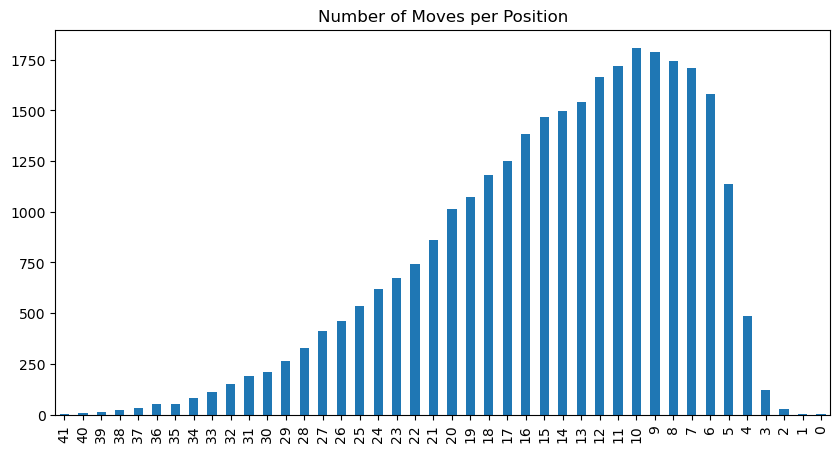

In [22]:
data['pieces'].value_counts().sort_index(ascending=False).plot(kind='bar', figsize=(10, 5), title='Number of Moves per Position')

In [23]:
# Update the DataFrame
data.loc[data['turn'] == -1, cel_columns] *= -1  # Flip -1 to 1 and 1 to -1
data['turn'] = 1  # Change turn to 1
data



,cel1,cel2,cel3,cel4,cel5,cel6,cel7,cel8,cel9,cel10,...,cel35,cel36,cel37,cel38,cel39,cel40,cel41,cel42,pieces,turn
0,0,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,1,1,-1,1,12,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,-1,1,1,-1,-1,-1,13,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,-1,1,-1,1,1,7,1
3,0,0,0,0,0,-1,0,0,0,0,...,-1,-1,1,0,1,-1,1,-1,17,1
4,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,-1,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30012,0,0,0,0,0,0,0,0,0,0,...,0,-1,1,-1,-1,0,1,1,10,1
30013,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,-1,1,0,1,0,9,1
30014,0,0,0,0,0,0,0,0,0,0,...,0,1,1,-1,-1,1,-1,1,17,1
30015,0,0,0,0,0,0,1,0,0,0,...,-1,1,-1,-1,1,-1,-1,1,21,1


In [24]:
i = 0
for index, row in data.iterrows():
    board = row[cel_columns].to_numpy().reshape(6, 7)  
    p1_count = np.sum(board == 1)
    p2_count = np.sum(board == -1)
    print(f"Row {index}: Player 1 pieces: {p1_count}, Player -1 pieces: {p2_count}")
    if  i==5: break
    

Row 0: Player 1 pieces: 6, Player -1 pieces: 6
Row 1: Player 1 pieces: 6, Player -1 pieces: 7
Row 2: Player 1 pieces: 3, Player -1 pieces: 4
Row 3: Player 1 pieces: 8, Player -1 pieces: 9
Row 4: Player 1 pieces: 2, Player -1 pieces: 3
Row 5: Player 1 pieces: 5, Player -1 pieces: 5
Row 6: Player 1 pieces: 10, Player -1 pieces: 11
Row 7: Player 1 pieces: 4, Player -1 pieces: 4
Row 8: Player 1 pieces: 4, Player -1 pieces: 5
Row 9: Player 1 pieces: 7, Player -1 pieces: 7
Row 10: Player 1 pieces: 12, Player -1 pieces: 12
Row 11: Player 1 pieces: 12, Player -1 pieces: 13
Row 12: Player 1 pieces: 3, Player -1 pieces: 4
Row 13: Player 1 pieces: 2, Player -1 pieces: 2
Row 14: Player 1 pieces: 6, Player -1 pieces: 6
Row 15: Player 1 pieces: 5, Player -1 pieces: 6
Row 16: Player 1 pieces: 4, Player -1 pieces: 4
Row 17: Player 1 pieces: 2, Player -1 pieces: 3
Row 18: Player 1 pieces: 6, Player -1 pieces: 7
Row 19: Player 1 pieces: 3, Player -1 pieces: 4
Row 20: Player 1 pieces: 6, Player -1 pieces

In [ ]:

path_file = os.path.join(p, 'results', 'monte_carlo_data.csv')
def generate_dataset(data, save_path=path_file):
    for index, row in data.iterrows():
        # Create a NumPy array board from the 'cel' columns
        board = row[cel_columns].to_numpy().reshape(6, 7)  # Assuming a 6x7 Connect Four board

        # Initialize the ConnectFour game with the board state
        game = ConnectFour()
        game.board = board
        game.turn = row['turn']  # Set the turn from the DataFrame

        # Create the root node for MCTS
        root = Node(game)

        # Initialize Monte Carlo Tree Search
        monte_carlo = MonteCarlo()

        # Perform the search to determine the best move
        played_column, _ = monte_carlo.search(root)

        # Store the played column in the DataFrame
        data.at[index, 'played'] = played_column

        print(f"Row {index}: Played column {played_column}")
        # Save the updated DataFrame to a new CSV file
        data.to_csv(save_path, sep=';', index=False)


# generate_dataset(data) # PLEASE BE CAREFUL WITH THIS FUNCTION, IT WILL TAKE A LONG TIME TO RUN AND WILL OVERWRITE THE FILE
#                        # POTENTIALLY LOSING THE ALREADY GENERATED DATA
#                        # FOR ME IT RUNNED FOR 1044 MINUTES GENERATING ABOUT 30000 ROWS